## Statistical Methods for the Physical Sciences (5214SMFA3Y)
## Individual mini-Project -- Model fitting and hypothesis testing: the search for WIMPs
### Timo Halbesma, 6126561, 2016/01/08

In [1]:
# Enable showing plots inside iPython notebook
%matplotlib inline

In [2]:
import scipy
from scipy import stats
import numpy
import matplotlib
from matplotlib import pyplot
import pandas

matplotlib.rcParams.update({'font.size': 22})

### Introduction
Current data from the Fermi gamma-ray observatory is providing hints of the existence of anomalous extended GeV gamma-ray emission at the centre of our galaxy. This GeV continuum emission is causing excitement in the astroparticle-physics community, because it may be associated with the decay of the hitherto-undetected weakly interacting massive particles (WIMPs), which are thought to make up dark matter.

This mini-project is based on analysing simulated spectral data from a hypothetical future gamma-ray observatory, whose main objective is to search for and study the extended dark matter decay signature in the centres of nearby galaxies. The data consists of a list of energies of photons detected in an observation of a nearby galaxy. Your task is to convert this data into a gamma-ray spectrum (this is just a histogram of photon numbers versus energy in discrete energy bins), carry out some simple tests and determine the shape of the continuum (with errors on the model parameters) as well as search for and characterise spectral emission lines.


### Objectives
_Important note_: throughout all of the following you should assume that in addition to any astrophysical source photons with spectra described below, there is an additional instrumental background photon continuum which contributes a constant number of photons per GeV. For the dataset you are given, $C = 1.5$ photons/GeV.

### Question 1
- The simple alternative to dark matter decay is that the continuum is produced by the combined unresolved emission from a large number of gamma-ray pulsars in the centre of the target galaxy. Assume that the spectrum of gamma-ray pulsars is a simple power- law following the relation: $$ dN = N_0 \left( \frac{E}{E_0} \right)^{-\Gamma} dE $$ where in our formalism, $dN$ is the number of photons expected in the infinitesimal energy range $dE$, and $N_0$ is the normalisation of the spectrum (in photons/GeV) at a fixed photon energy $E_0$. $\Gamma$ is the power-law index and is also known as the 'photon index'. Assuming that $\Gamma = 2$, use a _non-parametric significance test_ to compare the shape of this pulsar spectrum with that of your data (note that you don't need to know $N_0$!).

### Answer 1

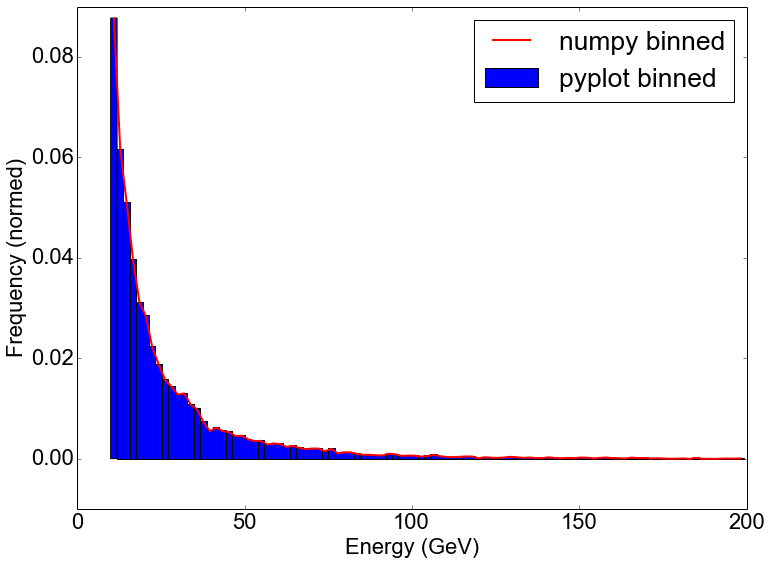

13.4279903729
The (Scipy built-in) K-S test gives us a D-value of 0.50505 corresponding to a p-value of 0.00000.
This means that with 1.00000 certainty we can say that the two samples are drawn from a different distribution.



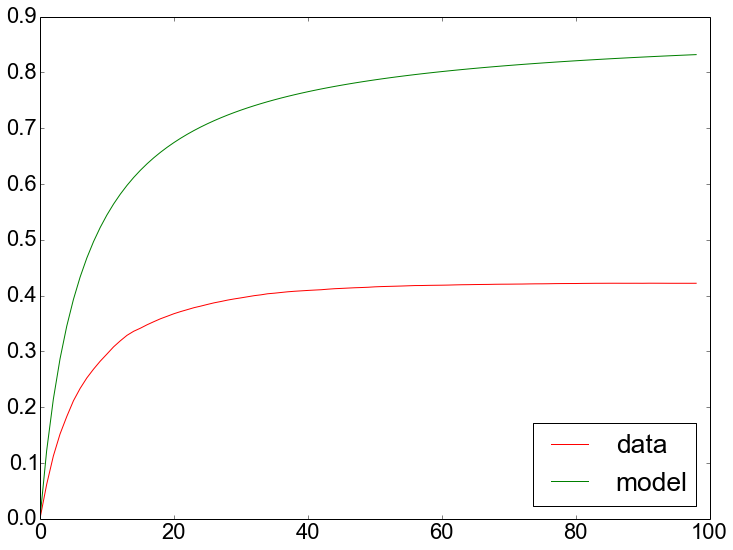

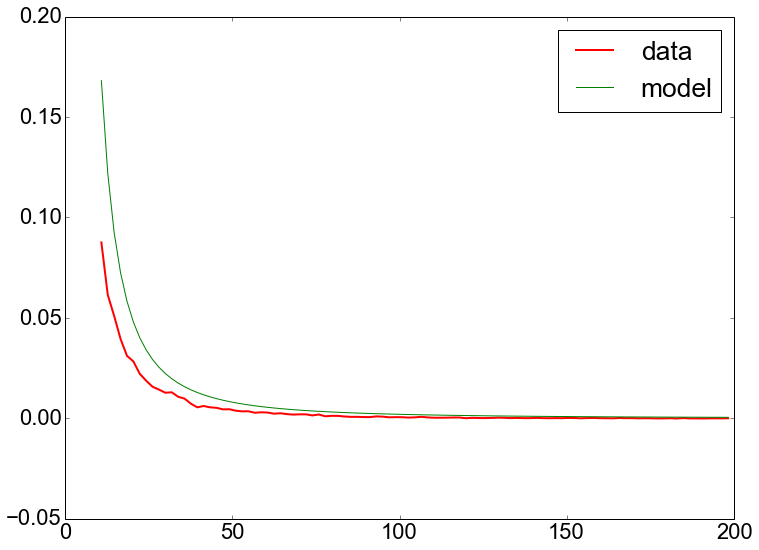

Spearman's Rho = 0.978824619532, p-value = 1.24482108353e-68
t = 47.0946406873


In [34]:
def parse_and_clean_dataset(filename="Halbesma_energies.txt"):
    ''' read data from file
        clean is not needed; file only contains one column with .2f '''
    energies = numpy.genfromtxt(filename, skiprows=0)
    
    return energies


def create_and_plot_histogram(energies, normalise=False, plot=False, steal_Riley_code=False):
    ''' create and plot a histogram of the data '''
    
    if steal_Riley_code:
        energies = energies / (numpy.mean(energies))
        counts, edges = numpy.histogram(energies, bins=50,
            range=[numpy.min(energies), numpy.max(energies)], density=False)
        counts = counts[counts > 20.]
        counts = pandas.Series(counts)
        edges = pandas.Series(edges)
        edges = edges[0:len(counts) + 1]
        x = edges[0:len(counts)]
        dens = pandas.Series(counts / (len(energies) * (edges[1] - edges[0])))
        err = numpy.sqrt(counts) / (len(energies) * (edges[1] - edges[0]))
        binsize = edges[1] - edges[0]
        # Now we can use the density values (dens) and error values (err), and define our models
        if plot:
            pyplot.figure(figsize=(12, 9))
            pyplot.plot(edges[:-1], dens, lw=3, color="black", linestyle="steps-mid")
            pyplot.ylabel("p(x)")
            pyplot.xlabel(r'$\frac{E}{<E>}$')
            # pyplot.tick_params(labelsize=15)
        return dens, edges, err

    
    # Bin up the data
    sample_size = len(energies)
    nr_of_bins = int(10*numpy.log(sample_size))
    energy_bin_frequency, energy_bin_edge = numpy.histogram(energies,
        bins=nr_of_bins, density=normalise)
    
    # Center the bin and calculate intrinsic error of bin
    energy_bin_center = numpy.zeros(nr_of_bins)
    error = numpy.zeros(nr_of_bins)
    
    # Correct for C = 1.5 photons/GeV
    binsize = energy_bin_edge[1] - energy_bin_edge[0]  # in GeV
    if not normalise:
        # assuming bin frequency is in photons
        energy_bin_frequency = energy_bin_frequency - (1.5 * binsize)
    else:
        # first convert photon count to normalised count
        background = (1.5 * binsize) / len(energies)
        energy_bin_frequency = energy_bin_frequency - background

    for i in range(nr_of_bins):
        energy_bin_center[i] = (energy_bin_edge[i] + energy_bin_edge[i+1])/2
    
        # Vaughaun (2013) eq. 2.4
        # error[i] = numpy.sqrt(numpy.std(energy_bin_frequency[i])/sample_size)
        
        error[i] = numpy.sqrt(energy_bin_frequency[i])

    if plot:
        # Plot histogram. Compare pyplot binning with numpy.hist binning.
        f, (ax1) = pyplot.subplots(1, 1, figsize=(12, 9))
        ax1.hist(energies, bins=nr_of_bins, facecolor='b',
                 label='pyplot binned', normed=normalise)  # not corrected for background photons!
        ax1.plot(energy_bin_center, energy_bin_frequency,
                 c='r', lw=2, label="numpy binned")

        ax1.set_xlabel("Energy (GeV)")
        ax1.set_ylabel("Frequency (normed)")

        ax1.legend(loc=1)
        pyplot.show()
    
    # We are interested in the binned arrays for further analysis.
    return energy_bin_frequency, energy_bin_center, error


def non_parametric_significance_test(energies, plot=False, steal_Riley_code=False):
    ''' Assume spectum of gamma-ray pulsars is simple power low (not dark matter decay)
            dN = N_0 (E/E_0)**(-Gamma) dE
            
        Assume Gamma = 2, then perform non-parametric significance test to compare shape
        of pulsar spectrum with that of the data
    '''
    
    # Normalising is important =)!
    energy_bin_frequency, energy_bin_center, error =\
        create_and_plot_histogram(energies, normalise=True, plot=False,
                                  steal_Riley_code=steal_Riley_code)
    
    if steal_Riley_code:    
        energy_bin_center = energy_bin_center[:-1]
    
    binsize = energy_bin_center[1] - energy_bin_center[0]
    dN = energy_bin_center**-2 * binsize
    dN = dN/numpy.sum(dN)
    print numpy.sum(energy_bin_frequency*energy_bin_center)
    
        
    # Perform Kolmogorov-Smirnov Test.
    # NB caution is required, because we cannot use the binned data in the ks_2samp function!
    
    # model_energies = numpy.zeros(len(energies))
    # Now draw data from the distribution and then use Scipy built-in function? If so, how O_o?
    
    (D_value, p_value) = scipy.stats.ks_2samp(energy_bin_frequency, dN)
    print "The (Scipy built-in) K-S test gives us a D-value of {0:.5f}".format(D_value),
    print "corresponding to a p-value of {0:.5f}.".format(p_value)
    
    certain = 1.0 - p_value

    print "This means that with {0:.5f} certainty we can say".format(certain),
    print "that the two samples are drawn from a different distribution."
    print
    
    # If we have our binned data and it is normalised (!), we can quite easily obtain the cdf
    dN_cdf = numpy.zeros(len(dN))
    energy_bin_frequency_cdf = numpy.zeros(len(dN))
    
    for i in xrange(1, len(dN)):
        dN_cdf[i] = dN_cdf[i-1] + dN[i]
        energy_bin_frequency_cdf[i] = energy_bin_frequency_cdf[i-1] + energy_bin_frequency[i]

    pyplot.figure(figsize=(12, 9))
    pyplot.plot(energy_bin_frequency_cdf, c="r", label="data")
    pyplot.plot(dN_cdf, label="model")
    pyplot.legend(loc=4)
    pyplot.show()
        
    
    if plot:
        f, (ax1) = pyplot.subplots(1, 1, figsize=(12, 9))
        ax1.plot(energy_bin_center, energy_bin_frequency,
                 c='r', lw=2, label="data")
        ax1.plot(energy_bin_center, dN, label="model")

        ax1.legend(loc=1)
        pyplot.show()
    
    # Calculate Spearman's rho correlation co-efficient
    n = len(energy_bin_frequency)
    rho, pval = scipy.stats.spearmanr(energy_bin_frequency, dN)
    t = rho * numpy.sqrt((n - 2) / (1 - rho**2))
    print "Spearman's Rho = {0}, p-value = {1}\nt = {2}".format(rho, pval, t)
    
    return


if __name__ == '__main__':
    energies = parse_and_clean_dataset()
    
    energy_bin_frequency, energy_bin_center, error =\
        create_and_plot_histogram(energies, normalise=True, plot=True)
        
    non_parametric_significance_test(energies, plot=True)
        
    


The Kolmogorov-Smirnov is implemented in Scipy. From the documentation:
> This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

> If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

Here we have a very low $p$-value, which would mean that we have to reject $H_0$ that the samples are drawn from the same distribution, so this would imply that the assumed model is very poor to describe the data. However, I have also provided a plot because if one were to visually inspect the data and the model, then we would expect the statistical test to suggest that the distributions may be the same. Even better solutions (by eye!) can be obtained when $N_0$ is not ignored, but set to 5 for instance (NB, in that case the K-S test yields an even lower $p$-value!)

The next non-parametric significance test we can perform is Spearman's Rho test. From the documentation:
>Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship

> The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, has same dimension as rho.

Here we see a high value $\rho$ in the order of unity. This means that both samples are correlated. The corresponding $p$-value given is the $p$-value for the null hypothesis $H_0$ that if the two sets of data are uncorrelated the obtained $\rho$ would have the same dimensions as found. This implies that the data are correlated, and the shape of the spectrum should be good to describe the data. Both tests do seem to contradict oneanother though.

** Different implementation for binning and plotting: Stealing Riley's work **

Since Riley was kind enough to provide solutions for the previous assignment, and this assignment is similar to the last question of the previous assignment: why not steal Riley's code? I mean, it's the teacher's code so it must be correct and this must be the way to go, right?

In the words of Riley: 
> Let's first load in the data, normalise the ~~count rate~~ **energy** values by the mean ~~count rate~~ **energy** (anticipating that it will be easier to optimize our fit with smaller x values), bin the ~~count rate~~ **energy** values into evenly-sized bins, and discard the bins in the tails of the distribution if they have < 20 counts. We can then calculate the error on the probability density of each bin based on the assumption that we can approximate the binning process as following a Poisson distribution (it actually follows a binomial distribution, since we are dealing with the probability that a given x-value is binned into the bin of interest). Then we can set error = $\sqrt{n}$, where $n$ is the number of values in the bin. This makes sense if you just notice that the variance of a Poisson distribution is the expected ~~count rate~~ **energy**. We then make a quick plot of the distribution, shown below.

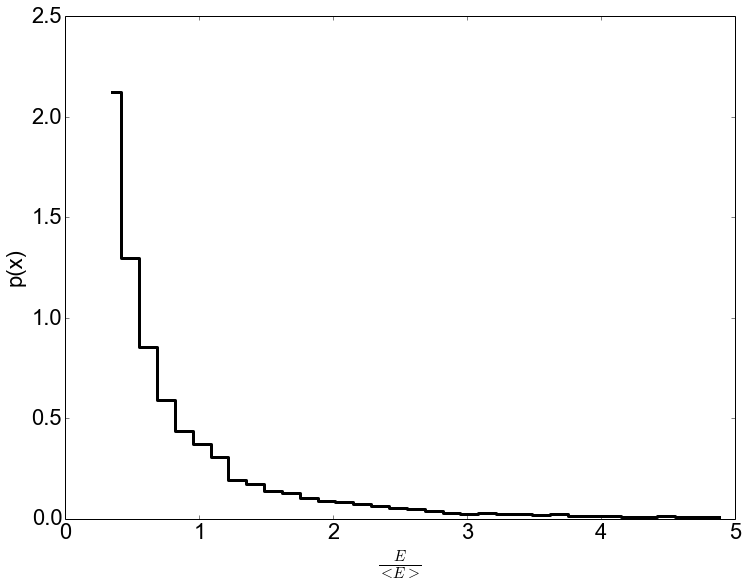

In [16]:
dens, edges, err = create_and_plot_histogram(energies, normalise=True, steal_Riley_code=True, plot=True)

** Also run the non-parametric significance test using Riley's binning method ** 

In [17]:
non_parametric_significance_test(energies, plot=False, steal_Riley_code=True)

The K-S test gives us a D-value of 0.25714 corresponding to a p-value of 0.16756.
This means that with 0.83244 certainty we can say that the two samples are drawn from a different distribution.

Spearman's Rho = 0.992854228109, p-value = 4.73681199152e-32
t = 47.7947417279


In [36]:
numpy.sum(dens*numpy.diff(edges))

0.98915053031040134

### Final answer for question 1

The data has been binned using the method I have written, and by copy-pasting Riley's code from the previous assignment, last question. The background subtraction has been done in my own code, but not in my copy-paste of Riley's code. 

Next, we have tried to perform a KS test and we computed Spearman's $\rho$. The problem with the K-S test as implemented in Scipy is that the documentation is somewhat lacking in completeness, but if I understand correctly it should eat unbinned data. For this reason we ignore the results of this function, and implemented the K-S function although the $p$-value is not calculated. This shows once more that built-in methods should never be used as a black box because (especially in statistics) because they do all kinds of nasty stuff. If we eyeball the shave of the binned spectrum and the given power law we see similiarities, which are confirmed by Spearman's $\rho$. Note that the results are very similar for my own binning method and for Riley's binning method (but also note that different number of bins are used). We could also change the code such that binning will be perfomerd in a logarithmic fashion, but then the bins are unevenly spaced in energy space, but evenly spaced in log(energy) space. As this could result in all kinds of nasty problems for the next question (fitting routine), we have chosen not to bin the data logarithmically.

### Question 2
- Fit the observed spectrum with continuum models and find the best-fitting model. You should compare the following three possibilities:
    - A simple power-law.
    - A broken power-law:
    $$ dN = N_0 \left( \frac{E}{E_0} \right)^{-\Gamma_1} dE \quad \rm{ for } E \leq E_{\rm bk} $$ $$ dN = N_0 \left( \frac{E_{\rm bk}}{E_0} \right)^{-\Gamma_1} \left( \frac{E}{E_{\rm bk}} \right)^{-\Gamma_2} dE \quad \rm{ for } E > E_{\rm bk} $$ where $E_{\rm bk}$ is the break energy and $\Gamma_1$ and $\Gamma_2$ denote respectively the photon indices below and above the break energy.
    - An exponentially cut-off power-law:
    $$ dN = N_0 \left( \frac{E}{E_0}\right)^{- \Gamma} \exp\left(-E/E_{\rm cut}\right) dE $$ where $E_{\rm cut}$ is the cut-off energy.

### Answer 2

[MLEs], chisq/dof: [ 1.  1.  1.  1.] nan
The p-value for the simple distribution is: nan
[MLEs], chisq/dof: [ 10.   2.   2.   2.   4.   2.] nan
The p-value for the broken distribution is: nan
[MLEs], chisq/dof: [ 10.   2.   2.   4.   2.] nan
The p-value for the exp_cut distribution is: nan


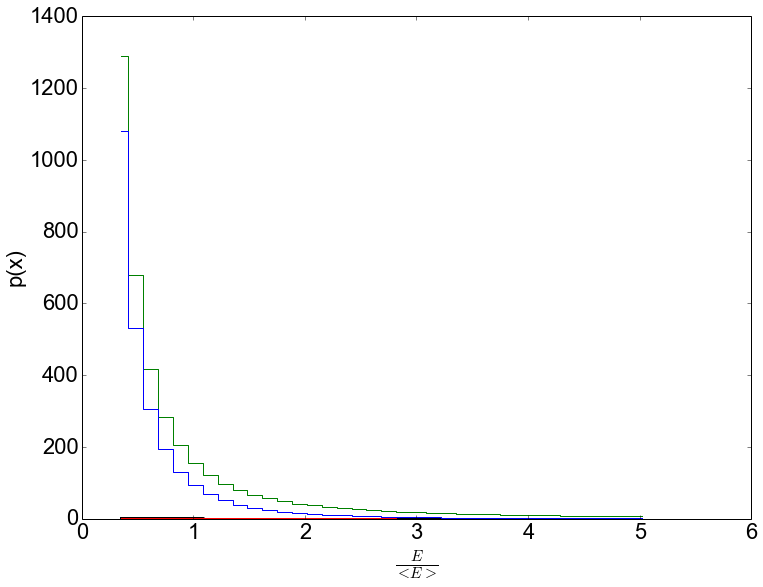

In [18]:
# Define our three models
def simple_power_law(parm, x):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma = parm[2]
    dE = parm[3]
    E = x
    
    dN = N_0 * (E/E_0)**(-1. * Gamma) * dE
    return dN


def broken_power_law(parm, x):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma_1 = parm[2]
    Gamma_2 = parm[3]
    dE = parm[4]
    E_bk = parm[5]  # Is this a fit parameter, though?
    
    E_below = x[x <= E_bk]
    E_above = x[x > E_bk]
    
    # E_below = x[numpy.where(x <= E_bk)]
    # E_above = x[numpy.where(x > E_bk)]                   
    
    dN_below = N_0 * (E_below/E_0)**(-1. * Gamma_1) * dE  
    dN_above = N_0 * (E_bk/E_0)**(-1. * Gamma_1) * (E_above/E_bk)**(-1. * Gamma_2) * dE
    
    # dN = numpy.concatenate(dN_below, dN_above)
    dN = pandas.concat([dN_below, dN_above])
    return dN


def exponentially_cut_off_power_law(parm, x):
    N_0 = parm[0]
    E_0 = parm[1]
    Gamma = parm[2]
    dE = parm[3]
    E_cut = parm[4]  # Is this a fit parameter, though?
    E = x
    
    dN = N_0 * (E/E_0)**(-1. * Gamma) * numpy.exp(-1. * E/E_cut) * dE
    return dN


# Define the statistical model, in this case we shall use a chi-squared distribution, assuming normality in the errors
def stat(parm, x, y, dy, dist):
    if dist == "simple":
        ymod = simple_power_law(parm, x)
    elif dist == "broken":
        ymod = broken_power_law(parm, x)
    elif dist == "exp_cut":
        ymod = exponentially_cut_off_power_law(parm, x)
    else:
        print "This function is not defined....choose another"
        return None
    
    X = sum((y - ymod)**2 / dy**2)
    return(X)


def fit_observed_spectrum_with_continuum_models(energy_bin_frequency, energy_bin_center, error,
                                                steal_Riley_code=False):
    if steal_Riley_code:
        dens, edges, err = energy_bin_frequency, energy_bin_center, error
        x = edges[0:len(energies)]
        
        # define an array of different dist names
        dists = ["simple", "broken", "exp_cut"]
        cols = ["red", "green", "blue"]
        # moddof = 3.
        fig, ax = pyplot.subplots(1, 1, figsize=(12, 9))
        ax.plot(edges[:-1], dens, lw=3, color="black", linestyle="steps-mid")
        ax.set_ylabel("p(x)")
        ax.set_xlabel(r'$\frac{E}{<E>}$')
        # ax.tick_params(labelsize=15)
        for i in xrange(len(dists)):
            if dists[i] == "simple":
                # [N_0, E_0, Gamma, dE]
                parm = [1., 1., 1., 1.]
            elif dists[i] == "broken":
                # [N_0, E_0, Gamma_1, Gamma_2, dE, E_bk]
                parm = [10, 2, 2, 2, 4, 2]
            elif dists[i] == "exp_cut":
                # [N_0, E_0, Gamma, dE, E_cut]
                parm = [10, 2, 2, 4, 2]
            result = scipy.optimize.minimize(stat, parm, args=(x, dens, err, dists[i]), method='Nelder-Mead')
            ml_vals = result["x"]
            ml_func = result["fun"]
            dof = len(x) - len(parm)
            print "[MLEs], chisq/dof:", ml_vals, ml_func/dof
            ch = scipy.stats.chi2(dof)
            pval = 1.0 - ch.cdf(ml_func)
            print "The p-value for the {0} distribution is: {1:.2f}".format(dists[i], pval)
            if dists[i] == "simple":
                ax.plot(x, simple_power_law(ml_vals, x), c=cols[i], drawstyle="steps-mid")
            elif dists[i] == "broken":
                ax.plot(x, broken_power_law(ml_vals, x), c=cols[i], drawstyle="steps-mid")
            elif dists[i] == "exp_cut":
                ax.plot(x, exponentially_cut_off_power_law(ml_vals, x), c=cols[i], drawstyle="steps-mid")


# fit_observed_spectrum_with_continuum_models(
#    energy_bin_frequency, energy_bin_center, error)
                
fit_observed_spectrum_with_continuum_models(
    dens, edges, err, steal_Riley_code=True)

### Question 3
- Search for emission lines, which may carry crucial information if they are associated with specific dark matter particle decays. You may assume a Gaussian profile to fit the emission line:
$$ dN = \frac{N_{\rm line}}{\sigma \sqrt{2 \pi}} \exp\left( \frac{(E - E_{\rm cent})^2)}{2 \sigma^2} \right) dE $$ where $E_{\rm cent}$ is the line centroid energy, $\sigma$ is the line width and $N_{\rm line}$ is the expected total number of photons contained in the line. The width of any lines is set by the instrumental resolution (which is a function of energy) and is given by:

$$ \sigma = 2.0 \sqrt{\frac{E_{\rm cent}}{200 \, \rm{ GeV}}} \, \rm{ Gev} $$

### Answer 3

### Question 4
- [Professor Denzil Dexter](http://www.teachertube.com/video/professor-denzil-dexter-81357) of the University of Southern California has proposed a dark matter candidate particle, the _Dextron_, which should result in a Gaussian emission line of width 1 GeV at an energy of 45.3 GeV. In case this line isn't detected, use your data to set a $3\sigma$ upper limit on the predicted number of photons that this line could contain.

Note that in all cases you should estimate $p$-values and significances for your hypothesis tests. You should explain your reasoning and choices and discuss how you interpret your results as you go along. Make sure that you make sensible decisions about how your report your results, e.g. about the number of significant figures used. You should also, in as much as possible, determine confidence intervals on the best-fitting model parameters (for continuum and emission line models). If errors appear to be correlated between parameters, you should also attempt to plot 2-dimensional confidence contours.Overall, we are looking for evidence that you understand and can apply the material in the course on model-fitting, parameter estimation and hypothesis testing, so you will find the information in the lectures in weeks 4, 5 and 6 to be very useful, as well as the case studies lecture from week 6.

### Answer 4